# STAT461 Project - Financial Time Series with Bayesian Inference
## Xavier Miles

The aim of this project is to investigate how Bayesian inference can be used in R to forecast time series data. The primary tool for this will be Bayesian linear regression and we will investigate using this model to predict the NZ GDP annual growth rate. The Bayesian approach is appealing because the priors can be used to impose restrictions/assumptions on the model, and this can help prevent overfitting, which is a common problem with time series data due to the number of parameters typically being large relative to the number of data points. The overfitting will not be such a concern when only using previous NZ GDP data, but becomes more important if other economic factors are included as explanatory variables.

## Theory

We will consider linear regression with normally distributed errors,
$$
Y_t = \beta X_t + \epsilon_t, \\
\epsilon \sim N(0,\sigma^2),
$$
so the parameters of interests are the variance of the errors, $\sigma^2$, and the coefficient vector, $\beta$. The posterior distribution can be expressed as
$$
p(\beta,\sigma^2 | Y_t) \propto p(Y_t | \beta,\sigma^2) \times p(\beta,\sigma^2),
$$
where $p(Y_t | \beta,\sigma^2)$ is the data/sampling distribution and $p(\beta,\sigma^2)$ is the prior distribution. To calculate the posterior distribution directly from this equation would require calculating marginal distributions, which can often be analytically intractable or computationally expensive. Instead we will use Gibbs Sampling algorithm which produces approximate sample values from the posterior distribution, given a full set of conditional distributions

## Gibbs Sampling
Suppose we are trying to find the marginal distribution of $n$ variables, given that their joint distribution is
$$
f(x_1, \dots, x_n).
$$
The Gibbs algorithm intitialises with values for all $n$ variables,
$$
x_1^0, \dots, x_n^0,
$$
and then sequentially sample each of the variables conditional on the other $n-1$ variables. For the first iteration this looks like
$$
f(x_1^1 | x_2^0, x_3^0, \dots, x_{n-1}^0, x_n^0) \\
f(x_2^1 | x_1^1, x_3^0, \dots, x_{n-1}^0, x_n^0) \\
f(x_3^1 | x_1^1, x_2^1, \dots, x_{n-1}^0, x_n^0) \\
\vdots \\
f(x_n^1 | x_1^1, x_2^1, x_3^1 \dots, x_{n-1}^1)
$$
which results in new values for all of the $n$ variables, $x_1^1,x_2^1,x_3^1,\dots,x_n^1$. This sequential updating of the $n$ variables is repeated many times (ie. tens of thousands), and it can be shown that the conditional distributions obtained converge (asymptotically) to the joint marginal distributions. This means that the mean of the draws provides an approximation to the mean of the posterior distribution, and other \dots

Typically, the first several thousand iterations are not included in posterior inference, as these are seen to be highly variable and not have converged sufficiently yet to be a decent approximation to the true joint marginal distributions. This collection of discarded iterations is referred to as the _burn-in period_.

## Implementation for GDP data

This section will run through using R to run a simple Gibbs sampler on NZ GDP annual growth rate data, given in quarterly periods. The data distribution will be an AR(2) model,
$$
GDP_t = c + \beta_1 GDP_{t-1} + \beta_2 GDP_{t-2} + \epsilon_t,
$$
where $\epsilon_t \sim N(0,\sigma^2)$. This means the model is assuming that the current period's GDP growth is only directly affected by the GDP growth of the two previous periods (past six months). This can also be expressed in matrix form,
$$
Y_t = \beta^T X_t + \epsilon_t, \\
$$
where $Y_t=GDP_t$, $\beta = (c, \beta_1, \beta_2)^T$ is the coefficient vector, and $X_t = (1, Y_{t-1}, Y_{t-2})^T$ is the data matrix. This means the objective of the Bayesian inference is to approximate the posterior distribution of the coefficients ($c$,$\beta_1$, and $\beta_2$) and the error variance ($\sigma^2$). This will be accomplished using the Gibbs sampler, which is an example of a Markov Chain Monte-Carlo (MCMC) method.

First, activate necessary packages and import the dataset. The dataset is imported from an excel document which was downloaded from the Reserve Bank of New Zealand (RBNZ) website. It is useful to convert the time series data into _ts_ objects, as there are provide more support than a matrix/data frame for handling time series data.

In [1]:
sink("NUL")  # Prevent messages being printed when loading packages
library(tidyverse)
library(readxl)
library(matrixStats)
library(magrittr)
library(fanplot)
sink()
set.seed(123456) # Reproducibility

GDP_all <- read_excel("RBNZ_data.xlsx", sheet = "GDP", range = "B4:G125") %>%
  set_colnames(c("Date","NZ","Aus","USA","Jap","UK"))
GDP_ts <- ts(GDP_all$NZ, start = c(1990,1), freq = 4)
GDP_ts_cropped <- window(GDP_ts, start = c(1990,1), end = c(2020,1))

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.3
v tibble  3.0.0     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract


New names:
* `` -> ...1



Next, define a function which will construct the $X$ matrix from a dataset, given the specified number of terms to include. Also, define a function which creates the companion matrix associated with the coefficient vector supplied to it, as this form will be useful later.

In [2]:
regression_matrix <- function(data, p, constant) {
  # Create an X matrix which contains the p lagged Y terms and a constant term.
  
  nrow <- as.numeric(dim(data)[1])
  nvar <- as.numeric(dim(data)[2])
  
  Y1 <- as.matrix(data, ncol = nvar)
  Y <- matrix(Y1[(p+1):nrow(Y1), ])
  
  X <- embed(Y1, p+1)  # Creates lagged variables
  X <- X[, (nvar+1):ncol(X)]
  if (constant) {
    X <- cbind(rep(1, (nrow-p)), X)
  }
  
  nvar2 <- ncol(X)
  
  return(list(Y = Y, X = X, nvar2 = nvar2, nrow = nrow))
}

companion_matrix <- function(coeff_vector) {
  # Convert the supplied coefficient vector into a companion matrix form.
  # This is useful for recasting an AR(2) as an AR(1).
  if (is.matrix(coeff_vector) == FALSE || ncol(coeff_vector) != 1) {
    stop("Error: coeff_vector must be a one-column matrix")
  }
  
  # Don't include constant term
  k <- nrow(coeff_vector) - 1 
  CM <- matrix(0, nrow = k, ncol = k)
  CM[2:k, 1:(k-1)] <- diag(1, nrow = k-1, ncol = k-1)
  CM[1, 1:k] <- coeff_vector[2:(k+1)]
  
  return(CM)
}

Now we can use the _regression_matrix_ function to generate the $X$ matrix for the GDP growth data with 2 lagged terms and a constant term.
The correct number of lagged terms to include in the model could be more objectively chosen through using autocorrelation and partial autocorrelation functions (ACF/PACF), but an arbitrary choice still allows us to appreciate the capabilities of a Bayesian approach to forecasting time series.

The _companion_matrix_ function generates the companion matrix for a coefficient vector. Suppose we have a coefficient vector $\beta=(\beta_1,\dots,\beta_n)^T$. The companion matrix corresponding to this coefficient vector is an $(n\times n)$ matrix with the first row being the coefficients, an $(n-1)\times(n-1)$ identity matrix below this, and zeroes in the final column.
\begin{equation}
    \begin{pmatrix}
        \beta_1 & \beta_2 & \dots  & \beta_{n-1} & \beta_n \\
        1       & 0       & \dots  & 0           & 0       \\
        0       & 1       & \dots  & 0           & 0       \\
        \vdots  & \vdots  & \ddots & \vdots      & \vdots  \\
        0       & 0       & \dots  & 1           & 0
    \end{pmatrix}
\end{equation}
This will be useful for calculating the stability of the model, which will be necessary later for the Gibbs sampler.

In [3]:
reg_output_GDP <- GDP_ts_cropped %>%
  as.matrix(ncol = 1) %>%
  regression_matrix(2, TRUE)
lagged_GDP <- reg_output_GDP$X
GDP_Y <- reg_output_GDP$Y
nrow <- reg_output_GDP$nrow
nvar <- reg_output_GDP$nvar2

Now we need to set the priors. For the $\beta$ coefficients, we will use a normal prior with zero mean and unit variance,
$$
\begin{pmatrix} c^0 \\ \beta_1^0 \\ \beta_2^0 \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 0 \end{pmatrix}, \qquad \sigma_{(c,\beta_1,\beta_2)}^2 = I_3,
$$
which are initialised as _Beta0_ and _Beta_var0_ below, repectively. For the $\sigma^2$ parameter/coefficient, we will use an inverse gamma prior,
$$
p(\sigma^2) \sim \Gamma^{-1}\left( \frac{T_0}{2}, \frac{\theta_0}{2} \right),
$$
as this is a very common choice. This is because the inverse gamma distribution is only defined for postive numbers and variance can only take postive values. In this case, the shape (_T0_) and scale (_theta0_) parameters were arbitrarily chosen, but these could be found more objectively using robustness tests.

In [4]:
# Priors
Beta0 <- as.matrix(rep(0,nvar), nrow = 1)  # Starting value of coeff. vector
Beta_var0 <- diag(1, nvar)                 # Variance of coeff. vector

sigma2 <- 1                                # Starting value of variance
T0 <- 1                                    # Shape
theta0 <- 0.1                              # Scale

As the necessary components of the model are defined/initialised, we can now consider the Gibbs sampler algorithm. The code to define the _gibbs_sampler_ function is included first, and then we will consider the code step-by-step to understand what is happening.

In [5]:
gibbs_sampler <- function(X,Y,Beta0,sigma0,sigma2,T0,theta0,reps,p,horizon) {
  nvar <- ncol(X)  # Number of explanatory/lagged variables
  out_coef <- matrix(0, nrow = reps, ncol = nvar+1)
  out_forecasts <- matrix(0, nrow = reps, ncol = horizon)
  
  cat("Iteration (in thousands): ")
  for (i in 1:reps) {
    if (i %% 1000 == 0) {
      cat(i/1000, " ", sep = "")
    }
    
    # Posterior mean and variance of the Normal dist. conditional on (B,sigma2)
    M <- solve(solve(Beta_var0) + as.numeric(1/sigma2) * t(X) %*% X) %*%
      (solve(Beta_var0) %*% Beta0 + as.numeric(1/sigma2) * t(X) %*% Y)
    
    V <- solve(solve(sigma0) + as.numeric(1/sigma2) * t(X) %*% X)
    
    chck_stblty <- -1
    while (chck_stblty < 0) {  # Check for stability
      Beta <- M + t(rnorm(p+1) %*% chol(V))
      b <- companion_matrix(Beta)
      max_abs_evalue <- max(sapply(eigen(b)$values, abs))
      
      # Check that not stationary for 3 lags (if abs(evalues)<1 forall evalues)
      if (max_abs_evalue <= 1) {
        chck_stblty <- 1
      }
    }
    # Compute residuals
    resids <- Y - X%*%Beta
    theta1 <- theta0 + t(resids)%*%resids
      
    # Draw from Inverse-Gamma to get sigma2 coefficient
    T1 <- nrow(Y)
    T2 <- T0 + T1
    z0 <- rnorm(T1, 1)
    sigma2 <- theta1 / (t(z0) %*% z0)
    #sigma2 <- extraDistr::rinvgamma(n = 1, alpha = T1/2, beta = theta1/2)
    
    # Store coefficients from the current iteration
    out_coef[i, ] <- matrix(c(Beta,sigma2), nrow = 1)
    
    # Compute 3-year forecasts
    yhat <- rep(0, horizon)
    end <- as.numeric(length(Y))
    yhat[1:2] <- Y[(end-1):end, ]
    
    X_mat <- c(1, rep(0,p))
    for (m in (p+1):horizon) {
      for (lag in 1:p) {
        # Create X matrix with p lags
        X_mat[lag+1] <- yhat[m-lag]
      }
      
      # Use X matrix to forecast yhat
      yhat[m] <- (X_mat %*% Beta) + (rnorm(1) * sqrt(sigma2))
    }
    out_forecasts[i, ] <- yhat
    
  }
  
  return(list(out_coef = out_coef, out_forecasts = out_forecasts))
}

repeats <- 20000
p <- 2
horizon <- 14
gibbs_output <- gibbs_sampler(lagged_GDP,GDP_Y,Beta0,Beta_var0,sigma2,T0,theta0,repeats,p,horizon)

Iteration (in thousands): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

Firstly, we need the following arguments to be supplied to the _gibbs_sampler_ function:
- The matrix of explanatory variables (X), which will be just the two lagged NZ GDP data produced by the _regression_matrix_ function earlier.
- The initial variable (Y), which will be the NZ GDP data (excluding the first two periods so it matches the lagged variables).
- The priors we defined earlier; Beta0, Beta_var0, sigma2, T0, theta0.
- The number of repeats (reps) for the Gibbs sampler. Not all of these repeats will be used during posterior inference, since the Gibbs sampler takes a certain number of repeats/iterations to converge to a sufficient degree of accuracy, but we will define the burn-in period and remove these repeats in the Results section.
- The horizon, which is how many periods we want to forecast plus the number of lagged terms. We chose a value of 14, which means that we are forecasting 12 periods for an AR(2) model. As the period for this dataset is quarters, 12 periods corresponds to 12 quarters or 3 years.

The function defines some output matrices and then all the computation is done within the large for-loop.
The first two steps in the for-loop are calculating the posterior mean and variance of the Normal distribution conditional on $\beta$ and $\sigma^2$. The mean of the posterior paramets $\beta$ is defined as
$$
    M = \left(\Sigma_0^{-1} + \frac{1}{\sigma^2}X_t^TX_t \right)^{-1} \left(\Sigma_0^{-1} \beta_0 + \frac{1}{\sigma^2}X_t^TY_t \right),
$$
and substituting the MLE for $Y_t$ gives
$$
    M = \left(\Sigma_0^{-1} + \frac{1}{\sigma^2}X_t^TX_t \right)^{-1} \left(\Sigma_0^{-1} \beta_0 + \frac{1}{\sigma^2}X_t^T X_t \beta_{OLS} \right),
$$
which illustrates how $M$ is a weighted average of the prior mean ($\beta_0$) and the MLE of the mean ($\beta_{OLS}$).
The variance of the posterior parameter $\beta$ is defined as
$$
    V = \left(\Sigma_0^{-1} + \frac{1}{\sigma^2}X_t^TX_t \right)^{-1},
$$
which is exactly the normalising constant from the equation for $M$. To get a random sample $B_+$ from the Normal distribution, with mean $M$ and variance $V$, we can sample a vector $B^*$ from a standard normal distribution and then apply the formula
$$
    B_+ = M + (B^* \times V^{-1/2})^T,
$$
which can just be viewed as the multidimensional generalisation of the equation used to calculate the z-score. The while-loop is checking whether the coefficient matrix/variable is stable and therefore verifying whether the model is dynamically stable. By recasting the AR(2) model as AR(1), the model is dynamically stable if the absolute values of the eigenvalues are less than one. (For more information about the dynamical stability of an AR model, see Chp. 17 of Fundamental Methods of Mathematical Economics.)

Now that we have the draw of the coefficient vector $\beta$, we will now draw $\sigma$ from the inverse-gamma distribution conditioned on this $\beta$. To obtain a sample $z$ from the inverse-gamma distribution with degrees of freedom $T/2$ and scale parameter $\theta/2$, we can use
$$
    z = \frac{\theta}{z_0^Tz_0},
$$
where $z_0$ is a vector of $T$ draws from a standard normal distribution. All of the coefficients are then saved into the _out_coef_ matrix.

The generated coefficients are then used to generate forecasts (yhat), which is then saved to the corresponding row of the _out_forecasts_ matrix. The equation for a 1-step ahead forecast can be written as
$$
    \hat{Y}_{t+1} = \alpha + \beta_1 \hat{Y}_t + \beta_2 \hat{Y}_{t-1} + \sigma \nu^*.
$$
The forecast is an AR(2) model with a random shock each period based on the draws of $\sigma$ (and a standard normally distributed variable).

The _gibbs_sampler_ function returns the matrix of randomly generated coefficients (_out_coef_) and the matrix of corresponding forecasts (_out_forecasts_).

## Posterior Estimates

Each draw of the Gibbs sampler gives us sample values for the parameters.
In the plots below, we can see that the $\beta$ coefficients look to be normally distributed, which would be expected since the prior and likelihood function were both defined to be normal. The $\sigma^2$ parameter seems to be roughly normally distributed, except for a slight right skew. 

The posterior means of the four parameters are also printed, and these are the posterior estimates for the corresponding parameter. Since $\beta_1$ estimate is positive, there is a positive relationship between the GDP of the current quarter and GDP of the previous quarter, meaning that a high GDP in one quarter means it is likely there will also be a high GDP in the next quarter (and vice versa). Since $\beta_2$ estimate is negative, there is a negative relationship between the GDP of the current quarter and GDP two quarters ago. 
The $\sigma$ estimate is relatively small, the volatility of the GDP numbers from quarter to quarter is relatively small; or equivalently, the GDP data from the two previous quarters can be used to predict the current GDP relatively accurately.

--Posterior medians--
c:      0.2679166
beta1:  1.66404
beta2: -0.759228
sigma:  0.06915444

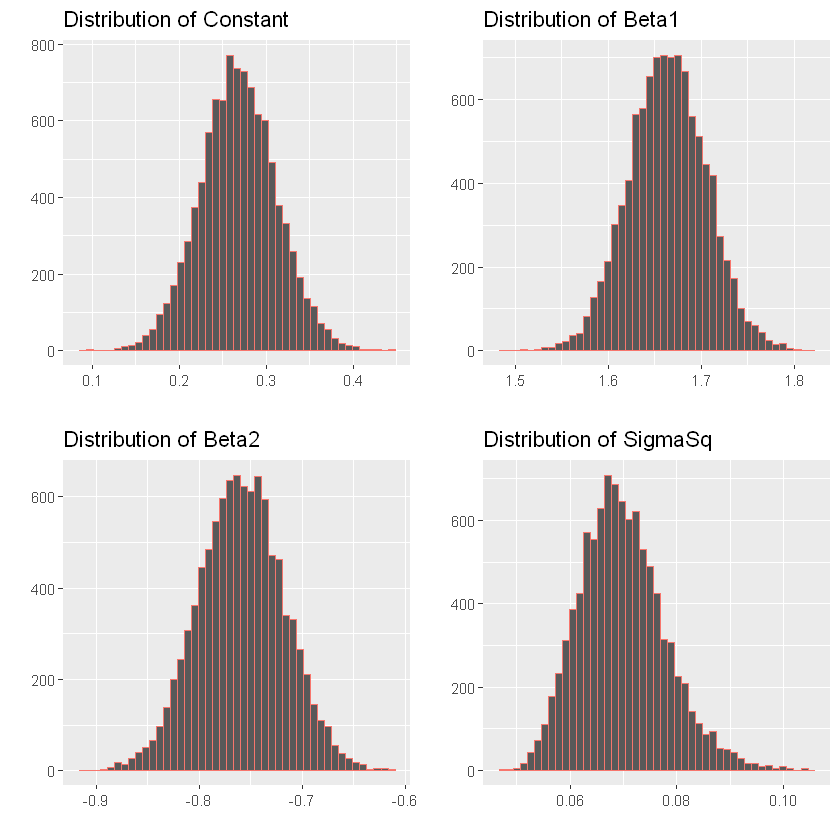

In [6]:
# Remove burn iterations
burn <- 10000
coef <- gibbs_output[["out_coef"]][(burn+1):repeats, ]
forecasts <- gibbs_output[["out_forecasts"]][(burn+1):repeats, ]

const <- median(coef[, 1])
beta1 <- median(coef[, 2])
beta2 <- median(coef[, 3])
sigma <- median(coef[, 4])
cat("--Posterior medians--\n", "c:      ", const, "\nbeta1:  ", beta1, 
    "\nbeta2: ", beta2, "\nsigma:  ", sigma, sep = "")

# Plot parameters:
const_plot <- qplot(coef[,1], geom = "histogram", bins = 45, xlab = "", 
                     main = "Distribution of Constant", colour = "#FF9999")  + 
  guides(colour = FALSE)
beta1_plot <- qplot(coef[,2], geom = "histogram", bins = 45, xlab = "",
                    main = "Distribution of Beta1", colour = "#FF9999") + 
  guides(colour = FALSE)
beta2_plot <- qplot(coef[,3], geom = "histogram", bins = 45, xlab = "",
                    main = "Distribution of Beta2", colour = "#FF9999") + 
  guides(colour = FALSE)
sigma_sq_plot <- qplot(coef[,4], geom = "histogram", bins = 45, xlab = "",
                    main = "Distribution of SigmaSq", colour = "#FF9999") + 
  guides(colour = FALSE)

gridExtra::grid.arrange(const_plot, beta1_plot, beta2_plot, sigma_sq_plot,
                        nrow = 2)

## Forecasts

The following code produces a plot which shows the previous and forecasted NZ GDP annual growth rates. The plot also includes the 95% credible interval for the forecasted values.

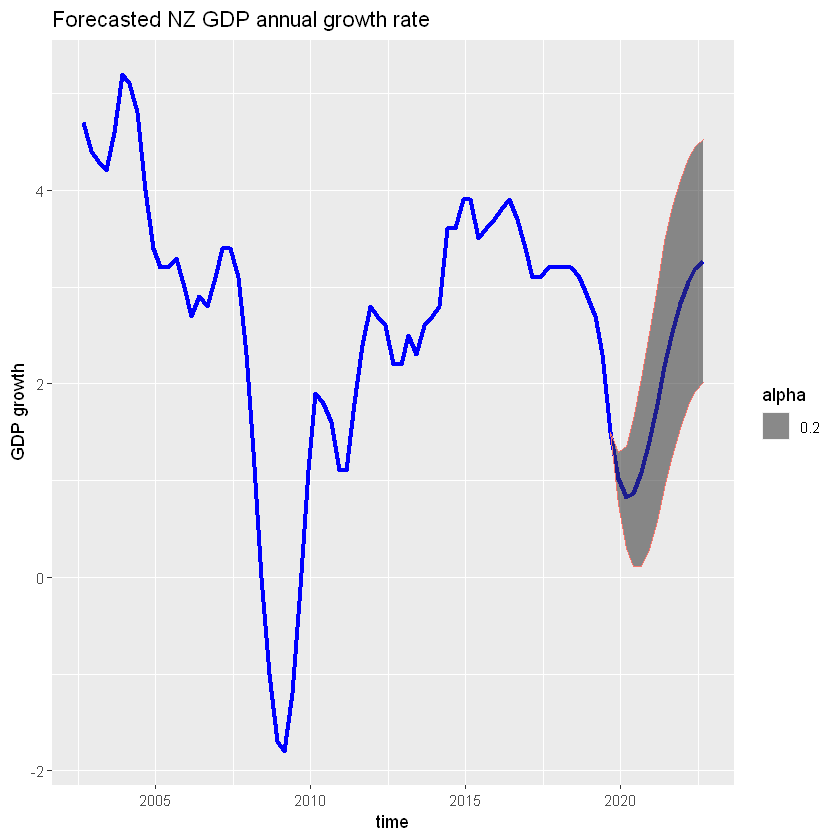

In [7]:
## Plotting forecasts ----------------------------------------------------------
# Need to use the parameters to construct forecasts and credible intervals.
forecasts_mean <- as.matrix(colMeans(forecasts))
forecasts_sd <- as.matrix(apply(forecasts, 2, sd))

# Create credible intervals around the forecasts
error_bands <- rbind(
  cbind(GDP_Y,GDP_Y),
  colQuantiles(forecasts, prob = c(0.16,0.84))[(p+1):horizon,]
)
all <- as.matrix(c(GDP_Y[1:(length(GDP_Y)-2)], forecasts_mean))
forecasts_mat <- cbind.data.frame(error_bands[,1], all, error_bands[,2]) %>%
  set_names(c("lower","mean","upper"))

# Create Date vector for plotting
date_vec <- seq(from = as.Date(GDP_all$Date[1]), by = "quarter", 
                length.out = nrow(forecasts_mat))

data_plot <- cbind(date_vec, forecasts_mat)
data_subset <- data_plot[(nrow(data_plot)-20*4):nrow(data_plot), ]
data_forecast <- data_plot[(nrow(data_plot)-horizon+p):nrow(data_plot), ]

ggplot(data_subset, aes(x = date_vec, y = mean)) +
  ggtitle("Forecasted NZ GDP annual growth rate") +
  labs(x = "time", y = "GDP growth") +
  geom_line(colour = "blue", lwd = 1.2) +
  geom_ribbon(data = data_forecast, aes(ymin = lower, ymax = upper, 
                                        colour = "bands", alpha = 0.2)) + 
  guides(colour = "none")

The following function just produces the same plot, but with nicer formatting and shading to show the quantiles of the credible interval for the forecasted values. It uses the _fanplot_ package for the "fanned" forecast credible interval.

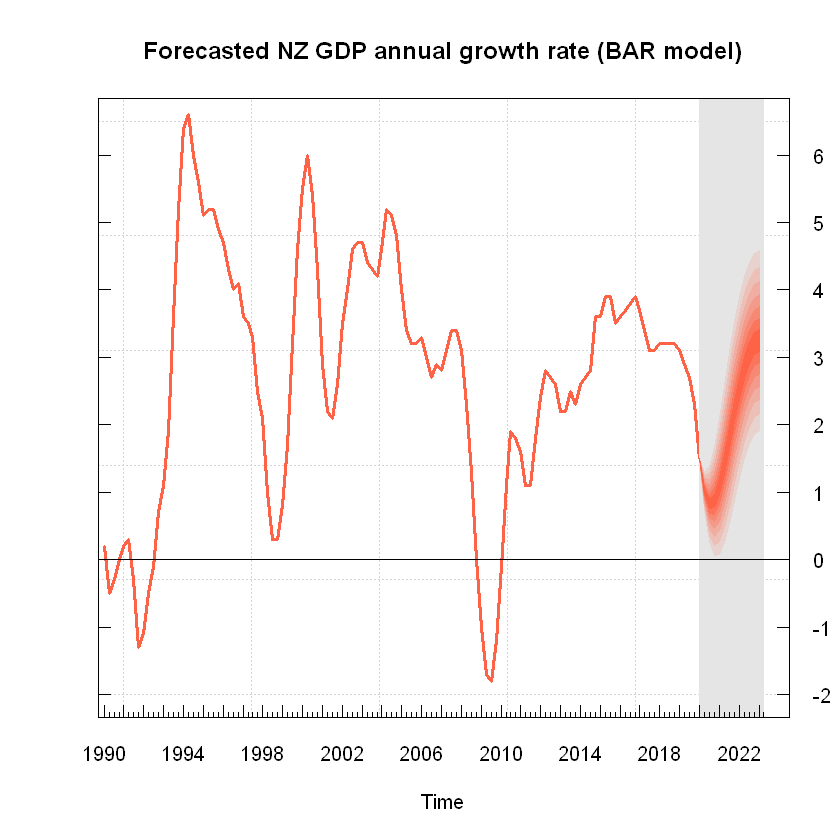

In [8]:
plot_fanplot <- function(forecasts, orig_data, y_limits, plot_title) {
    forecasts_median <- apply(forecasts, 2, median)
    forecasts_sd <- apply(forecasts, 2, sd)
    
    y0 <- 2020.25
    tt <- seq(y0, y0+11/4, by = 0.25)

    params <- cbind(tt, forecasts_median[-c(1,2)], forecasts_sd[-c(1,2)])
    probs <- seq(0.1, 0.9, by = 0.05)
    k <- nrow(params)
    bvar_GDP_plot <- matrix(NA, nrow = length(probs), ncol = k)
    for (i in 1:k) {
      bvar_GDP_plot[, i] <- qsplitnorm(probs, mode = params[i,2], sd = params[i,3])
    }
    
    # Plot past data
    plot(orig_data, type = "l", col = "tomato", lwd = 2.5,
         xlim = c(1991, y0+3), ylim = y_limits,
         xaxt = "n", yaxt = "n", ylab = "", 
         main = plot_title, panel.first = grid())
    # Background and fanchart for forecasted values
    rect(y0-0.25, par("usr")[3]-1, y0+3, par("usr")[4],
         border = "gray90", col = "gray90")
    fan(data = bvar_GDP_plot, data.type = "values", probs = probs, start = y0, freq = 4,
        anchor = orig_data[time(orig_data) == y0-0.25],
        fan.col = colorRampPalette(c("tomato","gray90")),
        ln = NULL, rlab = NULL)
    # Further aesthetics
    axis(2, at = -100:100, las = 2, tcl = 0.5, labels = FALSE)
    axis(4, at = -100:100, las = 2, tcl = 0.5)
    axis(1, at = 1990:2023, tcl = 0.5)
    axis(1, at = seq(1990, 2023.25, 0.25), labels = FALSE, tcl = 0.2)
    abline(h = 0)
}

plot_fanplot(forecasts, GDP_ts_cropped, c(-2,6.5),
             "Forecasted NZ GDP annual growth rate (BAR model)")

## Conclusion
Our forecast seems quite positive, with a mean predicted annual growth rate at around 3.2% by 2023.
There seems to be a fair bit of upside risk with the upper bound of the 95% credible interval reaching nearly 4.5% by 2023.
The graph indicates that it is highly unlikely that there will be negative NZ GDP growth over the next three years, with the lower bound of the 95% credible interval only just managing to avoid intersecting zero at it's lowest point. This is somewhat suprising considering how steeply the annual growth rate has been dropping in the last few periods and the generally pessimistic outlook of many people about prospects for the global economy over the next few years, but perhaps a (more complex) model which included other economic variables would forecast worse annual NZ GDP growth rates over the next few years.

# Expanded NZ Model

Now we are going to investigate how the posterior inference and posterior predictions will change if we use a model that incorporates more information. The previous model just used the NZ GDP data for the two preceding quarters. This expanded model will also include Consumer Price Index (CPI) and Trade Weighted Index (TWI), where the CPI is an inflationary metric and the TWI measures the exchange rate of NZD to New Zealand's major trading partners. Given that we are interested in forecasting the GDP for new periods, we will use lagged CPI and TWI explanatory variables for the previous two periods, as the CPI and TWI for the current period is assumed to be unknown.

This means the the Expanded NZ Model will be a Bayesian Vector Autoregression (BVAR) model, which is a multidimensional extension of the (Bayseian) AR model used previously, wherein a vector of time series variables is regressed on lagged vectors of these variables with preset prior distributions. We will use a BVAR model with 2 lags and 3 explanatory variables, which has the form
$$
    Y_t = c + B_1 Y_{t-1} + B_2 Y_{t-2} + \epsilon_t,
$$
where $Y_t = (GDP_t,CPI_t,TWI_t)^T$ is an $(n\times1)$ vector of variables, $B_1$ and $B_2$ are $(n\times n)$ coefficient matrices, and $\epsilon_t$ is an $(n\times1)$ vector of error terms.

Letting $x_t = (1, y_{t-1}, y_{t-2})$, then the design matrix is
$$
    X = \begin{pmatrix} GDP_t \\ CPI_t\\ TWI_t \end{pmatrix} =
    \begin{pmatrix}
        1 & GDP_{t-1} & GDP_{t-2} \\
        1 & CPI_{t-1} & CPI_{t-2} \\
        1 & TWI_{t-1} & TWI_{t-2}
    \end{pmatrix},
$$
which gives
$$
Y = X A + E,
$$
where $E = (\epsilon_1, \epsilon_2, \epsilon_3)^T$ and $\epsilon_1,\epsilon_2,\epsilon_3 \sim N(0, \Sigma)$.

For the priors of the BVAR model, we will use the multivariate extensions to the prior distributions used for the BAR model. This means a multivariate normal prior distribution for the coefficients,
$$
    \alpha | \Sigma,y \sim N(\hat{A}, \Sigma (XX')^{-1}),
$$
and an inverse-Wishart prior distribution for the error covariance matrix,
$$
    \Sigma^{-1} | y \sim W(S^{-1}, \nu)
$$
where $\hat{A}$ is the OLS estimate $(X'X)^{-1}X'Y$, $S$ is the multivariate squared-error $(Y-X\hat{A})'(Y-X\hat{A})$, and $\nu$ is the degrees of freedom (in this case 70).

To use this model in R, we can use the _bvartools_ library, which includes various tools to train, predict, and interpret BVAR models. The CPI and TWI data can be imported from the same RBNZ excel document used previously. We will restrict the period of the training data to [1990 Q1, 2020 Q1], which ensures there is data for all three economic variables at every timepoint.

In [9]:
library(bvartools)

CPI_all <- read_excel("RBNZ_data.xlsx", sheet = "CPI", range = "B4:C419", 
                      col_names = FALSE) %>%
  set_colnames(c("Date","CPI"))
CPI_ts <- ts(CPI_all$CPI, start = c(1916,3), freq = 4)
CPI_ts_cropped <- window(CPI_ts, start = c(1990,1), end = c(2020,1))

TWI_all <- read_excel("RBNZ_data.xlsx", sheet = "REALTWI", range = "B5:C611",
                      col_names = FALSE) %>%
  set_colnames(c("Date","TWI"))
TWI_ts <- ts(TWI_all$TWI, start = c(1970,1), freq = 12) %>%
  aggregate(nfreq = 4, FUN = function(months) {months[1]}) # Change to quarterly 
TWI_ts_cropped <- window(TWI_ts, start = c(1990,1), end = c(2020,1))

New names:
* `` -> ...1
* `` -> ...2

New names:
* `` -> ...1
* `` -> ...2



Now, combine all of the data into one multivariate _ts_ object. Plotting the three variables will give us some indication of their movement over time.
We would expect GDP growth and CPI growth to move in opposite directions, since inflation (CPI) will often discourage spending within an economy and thus dampen economic output (GDP). We can see GDP and CPI moving in opposite directions in the early 1990s and during the 2000 recession. The relationship between GDP and TWI seems less obvious, but since the relative strength of the NZD (ie TWI) affects both exports and imports, it is expect to affect the NZ economy's aggregate demand (via expenditure approach) and thus impact on NZ GDP growth.

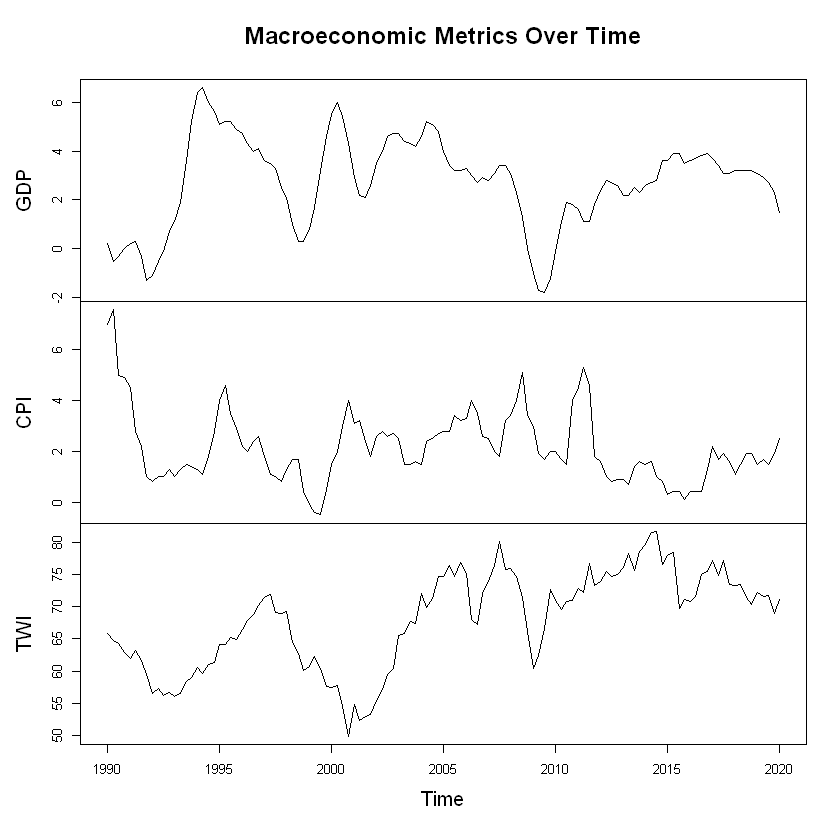

In [10]:
bvar_ts <- ts(cbind(GDP_ts_cropped,CPI_ts_cropped,TWI_ts_cropped), 
              start = c(1990,1), freq = 4, names = c("GDP","CPI","TWI"))
plot(bvar_ts, main = "Macroeconomic Metrics Over Time")

## Gibbs Sampler

We can use the _bvartools::gen_var_ function to generate the $Y$ and $X$ matrices.

In [11]:
bvar_data <- gen_var(bvar_ts, p = 2, deterministic = "const")
bvar_Y <- t(bvar_data$data$Y)
bvar_X <- t(bvar_data$data$Z)

We can calculate frequentist (or non-Bayesian) VAR coefficient estimates and error-covariance matrix estimate using the ordinary OLS equations, which is what the following code does.

In [12]:
B_freq <- tcrossprod(bvar_Y, bvar_X) %*% solve(tcrossprod(bvar_X))
round(B_freq, 3)

eps_freq <- bvar_Y - B_freq%*%bvar_X
eps_Sigma_freq <- tcrossprod(eps_freq) / (ncol(bvar_Y) - nrow(bvar_Y))
round(eps_Sigma_freq, 3)
# B denotes coefficient estimates, eps denotes error terms (epsilon)

,GDP.1,CPI.1,TWI.1,GDP.2,CPI.2,TWI.2,const
GDP,1.589,-0.063,0.037,-0.688,0.018,-0.045,0.908
CPI,0.081,0.992,0.031,-0.009,-0.216,-0.033,0.323
TWI,0.289,0.198,0.975,-0.196,-0.164,-0.033,3.621


,GDP,CPI,TWI
GDP,0.122,-0.045,0.144
CPI,-0.045,0.376,-0.181
TWI,0.144,-0.181,6.210


Now we will set up the required components for running a Gibbs sampler with this BVAR model, given noninformative priors. First we will define some parameters for the Gibbs sampler.

In [13]:
iter <- 30000           # Number of iterations of the Gibbs sampler
burnin <- 15000         # Number of burn-in samples
store <- iter - burnin  # Number of stored samples

tt <- ncol(bvar_Y)       # Number of observations
k <- nrow(bvar_Y)        # Number of response variables
m <- k * nrow(bvar_X)    # Number of estimated coefficients

Next, we will set up noninformative priors. The coefficient vector is set to zero and the diagonal elements of the corresponding covariance matrix $V$ are set to 1, except for coefficients corresponding to intercept terms which are set to 10. The prior degree of freedom of the error term is set to 6 and the diagonal elements of the scale matrix are set to 1. (Non-diagonal elements of $V$ and the scale matrix are zero.)

In [14]:
B_mu_prior <- matrix(0, m)                        # Vector of prior B means
B_V_inv_prior <- diag(1, m)                       # Inverse of the prior B cov matrix

eps_Sigma_degf_prior <- 6                         # Prior degrees of freedom
eps_Sigma_scale_prior <- diag(1, k)               # Prior Sigma
eps_Sigma_degf_post <- tt + eps_Sigma_degf_prior  # Posterior degrees of freedom

Next, we use the OLS estimates as starting values for the Gibbs sampler and create matrixes to store the posterior samples.

In [15]:
eps_Sigma_inv <- solve(eps_Sigma_freq)  #Initial values

draws_B  <- matrix(NA, m, store)
draws_Sigma <- matrix(NA, k^2, store)

Now we can use the _bvartools::post_normal_ function to generate approximate samples from the posterior distribution. This function was used since it uses a Gibbs sampler to generate the posterior samples, which is the algorithm we used for the BAR model earlier. Alternatively, the _BVAR_ package seems to be better-established package with slightly more functionality, but the function it offers to generate posterior samples (_bvar_) uses a different algorithm (Metropolis Hastings).

In [16]:
for (draw in 1:iter) {
    # Draw conditional mean parameters
    B  <- post_normal(bvar_Y, bvar_X, eps_Sigma_inv, B_mu_prior, B_V_inv_prior)
    
    # Draw covariance matrix
    eps  <- bvar_Y - matrix(B,k)%*%bvar_X  # Residuals
    eps_Sigma_scale_post <- solve(eps_Sigma_scale_prior + tcrossprod(eps))
    eps_Sigma_inv <- matrix(rWishart(1, eps_Sigma_degf_post, eps_Sigma_scale_post)[,,1], k)
    eps_Sigma  <- solve(eps_Sigma_inv)
    
    # Store relevant draws
    if (draw > burnin) {
        draws_B[, (draw-burnin)] <- B
        draws_Sigma[, (draw-burnin)] <- eps_Sigma
    }
}

## Posterior Estimates

We can take the posterior means of the $B$ draws as a point estimate for the coefficient matrix.

In [17]:
B_bayes <- rowMeans(draws_B) %>%
  matrix(k) %>%
  round(3) %>%
  set_rownames(dimnames(bvar_Y)[[1]]) %>%
  set_colnames(dimnames(bvar_X)[[1]])

print(B_bayes)

    GDP.1  CPI.1 TWI.1  GDP.2  CPI.2  TWI.2 const
GDP 1.584 -0.062 0.038 -0.682  0.019 -0.044 0.783
CPI 0.084  0.983 0.031 -0.011 -0.208 -0.033 0.333
TWI 0.338  0.180 0.983 -0.218 -0.082  0.001 0.617


Since we are interested in predicting the GDP growth rate, only the first row is important to us, which gives
$$
    GDP_t = 0.780 + 
    \begin{pmatrix} 1.585 & -0.063 & 0.038 \end{pmatrix} \begin{pmatrix} GDP_{t-1}\\ CPI_{t-1}\\ TWI_{t-1} \end{pmatrix} +
    \begin{pmatrix} -0.012 & -0.208 & -0.033 \end{pmatrix} \begin{pmatrix} GDP_{t-2}\\ CPI_{t-2}\\ TWI_{t-2} \end{pmatrix} +
    \epsilon_{t,GDP}.
$$
We can see that the GDP growth rate has a negative relationship with the CPI of both previous quarters. This makes sense since higher inflation CPI is seen as leading to worse economic growth (GDP). However, it is interesting that the current GDP growth rate has a stronger relationship with the CPI from 2 quarters ago than the CPI from 1 quarter ago. This might be because the macroeconomic factors may take longer than three months to affect each other.

The GDP growth rate has a positive and negative relationship with the TWI from one and two quarters ago, repectively. The magnitude of these coefficients is far smaller than the magnitude of the coefficients for CPI, which means the lagged TWI is less influential in predicting the current/future GDP growth rate.

We can take the posterior means of the $\Sigma$ draws as a point estimates for the covariance matrix.

In [18]:
Sigma  <- rowMeans(draws_Sigma) %>%
  matrix(k) %>%
  round(2) %>%
  set_rownames(dimnames(bvar_Y)[[1]]) %>%
  set_colnames(dimnames(bvar_Y)[[1]])

print(Sigma)

      GDP   CPI   TWI
GDP  0.13 -0.05  0.15
CPI -0.05  0.39 -0.18
TWI  0.15 -0.18  6.36


We will save the relevant output of the Gibbs sampler into a _bvar_ object, which will mean we can use the posterior sample with other helpful functions in the _bvartools_ library.

In [19]:
bvar_obj <- bvar(y = t(bvar_Y), x = t(bvar_X), 
                 A = draws_B[1:18,], C = draws_B[19:21,],
                 Sigma = draws_Sigma)
summary(bvar_obj)
bvar_obj_thin <- thin_posterior(bvar_obj, thin = 15)


Model:

y ~ GDP.1 + CPI.1 + TWI.1 + GDP.2 + CPI.2 + TWI.2 + const

Variable: GDP 

          Mean      SD  Naive SD Time-series SD     2.5%      50%    97.5%
GDP.1  1.58410 0.06466 0.0005279      0.0005279  1.45831  1.58335  1.71064
CPI.1 -0.06229 0.05218 0.0004260      0.0004260 -0.16364 -0.06233  0.04090
TWI.1  0.03782 0.01379 0.0001126      0.0001157  0.01031  0.03790  0.06511
GDP.2 -0.68234 0.06325 0.0005165      0.0005165 -0.80572 -0.68240 -0.55725
CPI.2  0.01913 0.05047 0.0004121      0.0004121 -0.08063  0.01903  0.11887
TWI.2 -0.04397 0.01390 0.0001135      0.0001171 -0.07141 -0.04400 -0.01666
const  0.78312 0.31012 0.0025321      0.0025827  0.16582  0.78377  1.39012

Variable: CPI 

          Mean      SD  Naive SD Time-series SD     2.5%      50%    97.5%
GDP.1  0.08416 0.10891 0.0008892      0.0008892 -0.12859  0.08293  0.29768
CPI.1  0.98297 0.08881 0.0007251      0.0007251  0.80911  0.98293  1.15726
TWI.1  0.03142 0.02373 0.0001938      0.0001938 -0.01470  0.03114  0.07744

The posterior sample/draws can be thinned with the _thin_posterior_ function, but we will not do this as there is no clear evidence that this is helpful for inference/predictions.

## Forecasts

Forecasts with credible bands can apparently be obtained using the _predict.bvar_ function, but this function does not seem to work, so we will calculate the forecasts manually. My manual predictions mostly followed the source code for _predict.bvar_ function anyway, with specific focus on implementing the equations which generate the error terms.

Because of the structure of the BVAR model, we also get forecasts for the CPI and TWI metrics for the same number of future periods.

In [20]:
# bvar_pred <- predict(bvar_obj_thin, n.ahead = 12, new_D = rep(1, 12))

horizon <- 14
GDP_forecasts <- matrix(0, nrow = store, ncol = horizon)
CPI_forecasts <- matrix(0, nrow = store, ncol = horizon)
TWI_forecasts <- matrix(0, nrow = store, ncol = horizon)

for (iter in 1:store) {
    # Compute 3-year/12-period forecasts
    yhat <- matrix(0, nrow = horizon, ncol = 3)
    end <- ncol(bvar_Y)
    yhat[1:2, ] <- t(bvar_Y[, (end-1):end])

    X_mat <- matrix(data = c(rep(0,p*nrow(bvar_Y)), 1), ncol = 1)
    for (m in (p+1):horizon) { # Loop over periods to forecast
        # Generate error
        temp <- eigen(matrix(bvar_obj[["Sigma"]][iter, ], nrow = k))
        u  <- temp$vectors %*% diag(sqrt(temp$values)) %*% t(temp$vectors) %*% stats::rnorm(3)
        #print(u)
        # Generate X matrix from previous p periods
        for (lag in 1:p) {
            X_mat[(3*lag-2):(3*lag), 1] <- yhat[m-lag,]
        }

        # Use X matrix to forecast yhat (with generated error)
        yhat[m, ] <- matrix(draws_B[,iter], nrow = 3) %*% X_mat + u
    }
    
    GDP_forecasts[iter, ] <- t(yhat[,1])
    CPI_forecasts[iter, ] <- t(yhat[,2])
    TWI_forecasts[iter, ] <- t(yhat[,3])
}

## Plotting

Now we can plot the median of the GDP growth forecasts for the next three years, which represents our posterior estimate for the future. Since the data ends at 2020 Q1, these forecasts will be from 2020 Q2 till 2023 Q1.

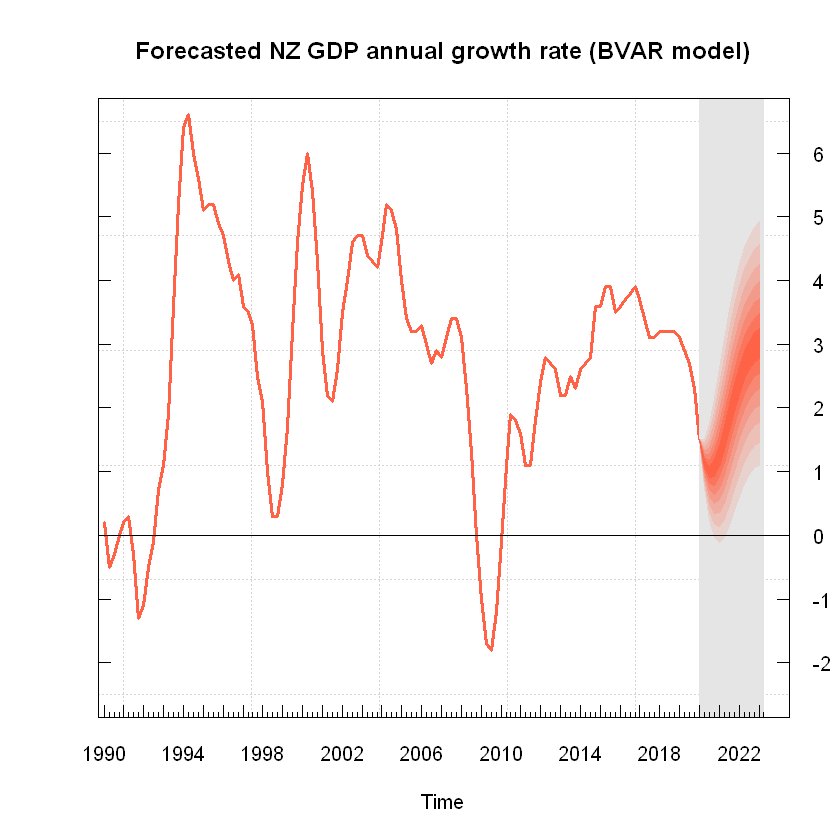

In [21]:
plot_fanplot(GDP_forecasts, GDP_ts_cropped, c(-2.5, 6.5),
             "Forecasted NZ GDP annual growth rate (BVAR model)")

Since this BVAR model includes both CPI and TWI, it is incorporating more information into the predictions the BAR model which only included GDP growth data.
The confidence bands are wider than for the BAR model, which indicates that the lagged three variables indicate more variability in the forecasts than the lagged GDP alone.

Since we have the forecasts for CPI and TWI, we can also plot these using the _plot_forecasts_ function.

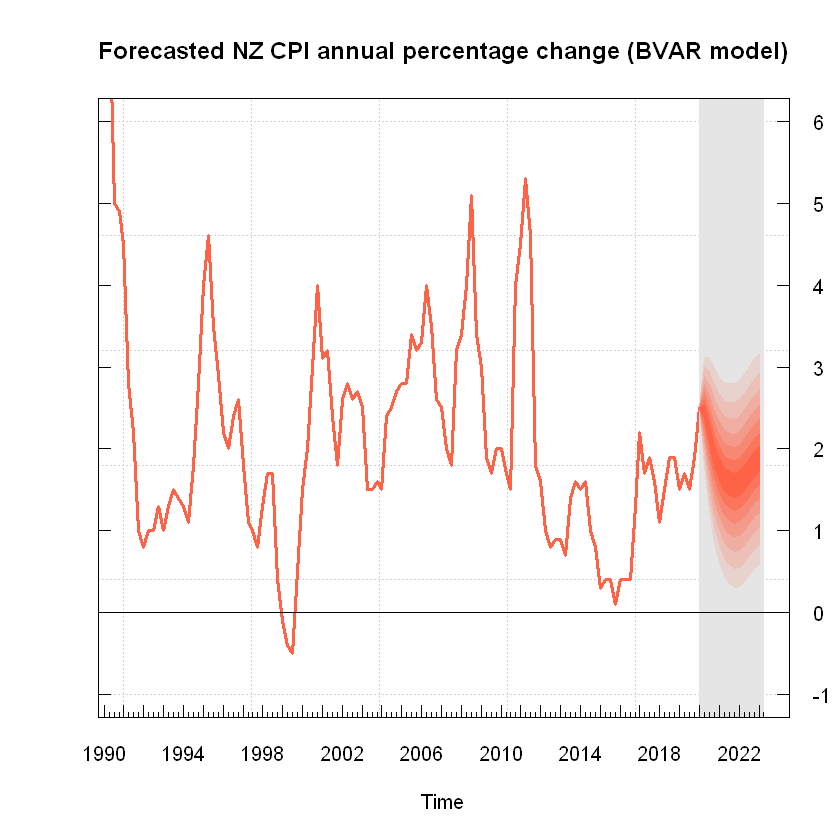

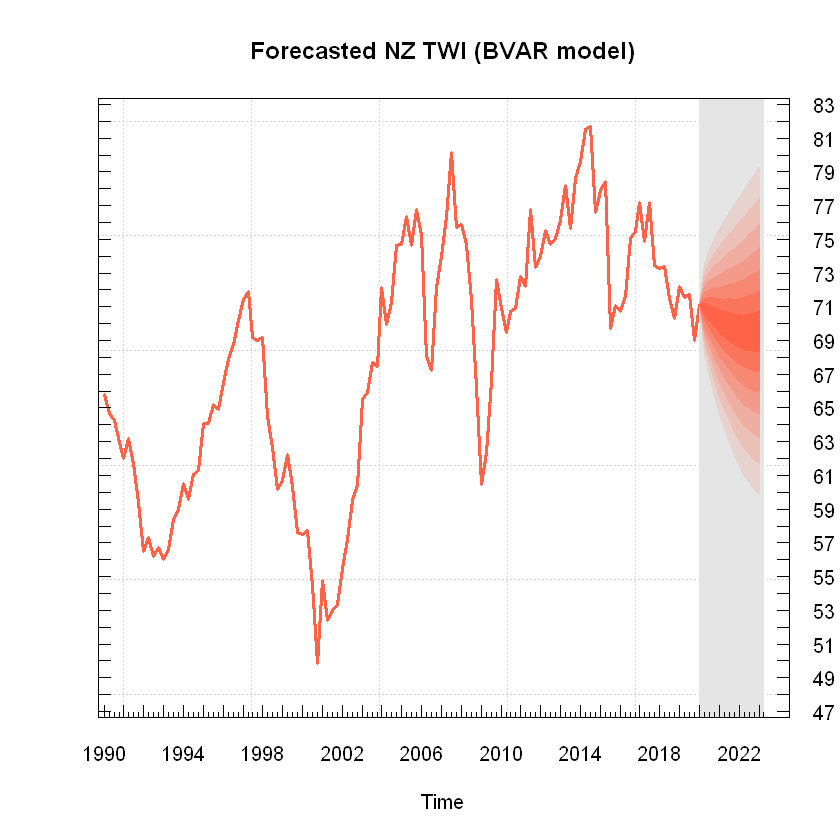

In [22]:
plot_fanplot(CPI_forecasts, CPI_ts_cropped, c(-1,6),
             "Forecasted NZ CPI annual percentage change (BVAR model)")
plot_fanplot(TWI_forecasts, TWI_ts_cropped, c(48,82),
             "Forecasted NZ TWI (BVAR model)")

The forecasted values for CPI % change have a narrower confidence band than the forecasted values for GDP. From the plot, we can see that the CPI seems to have a less consistent trend over time, which would mean that the lagged CPI variables are not as strongly related to the current CPI variable. However, the BVAR model also uses lagged GDP and TWI variables to predict these CPI values, which means that CPI has a weaker relationship than GDP with all three of these lagged macroeconomic indicators.

The forecasted values for TWI have an extremely wide confidence band, which means that we cannot have much confidence in the prediction.
As a point estimate, we expect the TWI to be about 70 over the next three year-period, but the 95\% credible interval spans from 60 to 80 by the end of 2023.

## Conclusion

Our forecast from the BVAR model still seems quite positive, and has fairly similar results to the BAR model, with an average predicted annual growth rate of around 3.2% by 2023. The major difference between the forecasts from both models is the confidence bands, which are slightly wider for the BVAR than the VAR model. This means that the revised predicted GDP growth has more downside and upside risk, and by 2023 the lower and upper bounds of the credible interval are 1% and 5%, respectively.

The BVAR model does have it's 95% credible interval including zero at about 2020 Q3. 
Both of these models did not work well in practice, with the GDP growth rate for 2020 Q2 dropping to -2%. However, these models can only predict based on what are included and will not tend to forecast for unusual events, such as a global pandemic and recession.
There was two large recessions in the training set, around 1999 Q4 and 2008 Q1, but the vector autoregressive recognises that these are not normal economic behaviour, and so will tend not to predict them in the future.

An improvement to this model might be to include a t-distribution for the error terms, as this is a more robust model and can better handle to unusual/extreme events. However, this might mean that model is not influenced as much by previous unusual events (ie recessions) and would therefore forecast that it is even less likely for zero or negative GDP growth to occur in the future three-year period.

The BVAR model could be extended to an arbitrary number of NZ economic measures (variables), with CPI growth and TWI being used in this project since there is the strongest theory for them to relate to the GDP growth. An alternative model could also include economic measures from other countries, such as the GDP growth in Australia, USA, and UK, as it would be expected that the economic condition/activity of New Zealand's trading partners is related to the economic condition/activity of New Zealand itself. This global model might pick up on economic trends that are occurring worldwide, but have not yet translated into changes in the NZ economy/GDP.